In [1]:
import os
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

from utils.utils import npz_in_folder
from utils.generator import SimpleDataFromNpzGenerator
from DDC_models.audio_models import audio_model

Using TensorFlow backend.


### Parameters

In [2]:
save_dir = '../models'
name_prefix = 'DDC_audio_model'
name_suffix = '{epoch:03d}.h5' 
model_name = 'panotti'

num_classes = 2
batch_size = 32
epochs = 200
dim = (128,173,1)

### Data

In [3]:
train = np.array(npz_in_folder('../data/audio'))
np.random.shuffle(train)
group = np.core.defchararray.rfind(train,'FAKE')==14
print('(REAL,FALSE)=',np.bincount(group))

(REAL,FALSE)= [5150 1500]


### Model

In [4]:
model = audio_model(model_name)

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (Conv2D)               (None, 128, 173, 32)      320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 86, 32)        0         
_________________________________________________________________
activation_1 (Activation)    (None, 64, 86, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 86, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 86, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 43, 32)        0         
_________________________________________________________________
activation_2 (Activation)    (None, 32, 43, 32)        0         
__________

### Fit

In [9]:
lr_reducer = ReduceLROnPlateau(factor=0.2,
                               cooldown=0,
                               patience=2,
                               min_lr=0.5e-6)

earlystop = EarlyStopping(monitor='val_loss',
                          patience=6)

In [10]:
from sklearn.model_selection import train_test_split

X, test = train_test_split(train, test_size=0.2, shuffle=True)

group = np.core.defchararray.rfind(X,'FAKE')==14
print('X --> (REAL,FALSE)=',np.bincount(group))
group = np.core.defchararray.rfind(test,'FAKE')==14
print('test --> (REAL,FALSE)=',np.bincount(group))

! date
training_generator = SimpleDataFromNpzGenerator(npzfiles=X, dim=dim)
validation_generator = SimpleDataFromNpzGenerator(npzfiles=test, dim=dim)

checkpoint = ModelCheckpoint(filepath=f'{save_dir}/{name_prefix}.{model_name}.{name_suffix}',
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True)

history = model.fit_generator(generator=training_generator,
                              epochs=epochs,
                              validation_data=validation_generator,
                              callbacks=[checkpoint, lr_reducer, earlystop],
                              #use_multiprocessing=True,
                              #workers=6,
                              max_queue_size=30)

X --> (REAL,FALSE)= [4149 1171]
test --> (REAL,FALSE)= [1001  329]
Mon Mar  9 00:40:53 UTC 2020
Epoch 1/200
166/166 [==============================] - 136s 820ms/step - loss: 3.5440 - acc: 0.7801 - val_loss: 3.9908 - val_acc: 0.7523

Epoch 00001: val_loss improved from inf to 3.99078, saving model to ../models/DDC_audio_model.panotti.001.h5
Epoch 2/200
166/166 [==============================] - 133s 804ms/step - loss: 3.5380 - acc: 0.7805 - val_loss: 4.0031 - val_acc: 0.7515

Epoch 00002: val_loss did not improve from 3.99078
Epoch 3/200
166/166 [==============================] - 133s 803ms/step - loss: 3.5501 - acc: 0.7797 - val_loss: 3.9908 - val_acc: 0.7523

Epoch 00003: val_loss did not improve from 3.99078
Epoch 4/200
166/166 [==============================] - 134s 810ms/step - loss: 3.5440 - acc: 0.7801 - val_loss: 3.9909 - val_acc: 0.7523

Epoch 00004: val_loss did not improve from 3.99078
Epoch 5/200
166/166 [==============================] - 133s 798ms/step - loss: 3.5531 - ac

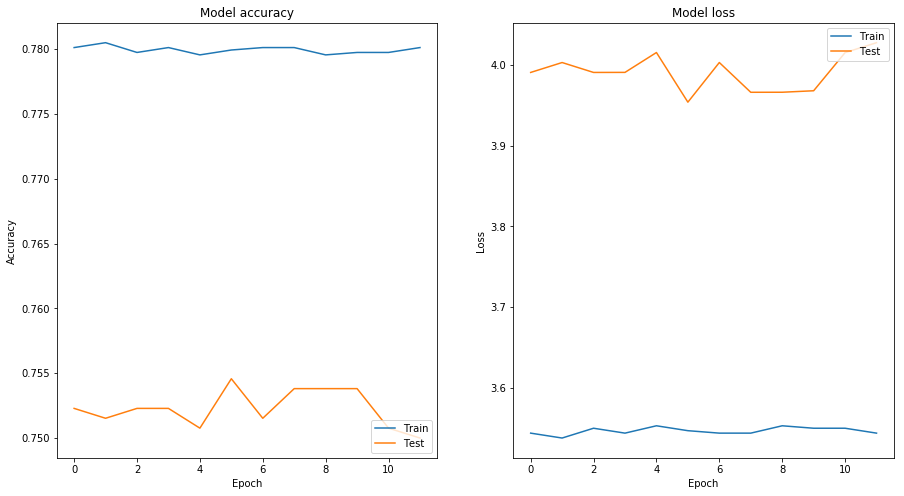

In [11]:
f, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize=(15, 8))

# Plot training & validation accuracy values
ax1.plot(history.history['acc'])
ax1.plot(history.history['val_acc'])
ax1.set_title('Model accuracy')
ax1.set(xlabel="Epoch", ylabel="Accuracy")
ax1.legend(['Train', 'Test'], loc='lower right')

# Plot training & validation loss values
ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('Model loss')
ax2.set(xlabel="Epoch", ylabel="Loss")
ax2.legend(['Train', 'Test'], loc='upper right')

plt.show()